## 📌 Project Objective

The goal of this project is to perform an end-to-end analysis of retail transaction data — starting from data cleaning and preprocessing, followed by exploratory data analysis (EDA), and finally extracting business insights related to revenue, customer behavior, and product performance.

This notebook focuses on:

- Cleaning and preparing a real-world style dataset containing missing and inconsistent values  
- Analyzing sales performance by product category  
- Understanding the effect of discount usage on customer spending  
- Identifying high-value customers through CLV (Customer Lifetime Value) analysis  
- Examining repeat customer behavior similar to SaaS-style retention analysis  

The final outcome is a fully cleaned dataset and a set of actionable insights that could support business decisions such as pricing strategy, retention focus, and category prioritization.

### Importing Required Libraries

In [87]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

In [88]:
df = pd.read_csv("retail_store_sales.csv")

In [89]:
df.head()

,Transaction ID,Customer ID,Category,Item,Price Per Unit,Quantity,Total Spent,Payment Method,Location,Transaction Date,Discount Applied
0,TXN_6867343,CUST_09,Patisserie,Item_10_PAT,18.5,10.0,185.0,Digital Wallet,Online,2024-04-08,True
1,TXN_3731986,CUST_22,Milk Products,Item_17_MILK,29.0,9.0,261.0,Digital Wallet,Online,2023-07-23,True
2,TXN_9303719,CUST_02,Butchers,Item_12_BUT,21.5,2.0,43.0,Credit Card,Online,2022-10-05,False
3,TXN_9458126,CUST_06,Beverages,Item_16_BEV,27.5,9.0,247.5,Credit Card,Online,2022-05-07,NaN
4,TXN_4575373,CUST_05,Food,Item_6_FOOD,12.5,7.0,87.5,Digital Wallet,Online,2022-10-02,False


## Initial Data Overview

Before diving into data cleaning and preprocessing, let's first take a look at the structure and basic properties of the dataset.  
By inspecting the data types, number of entries, and presence of missing values, we can better understand what kinds of cleaning tasks may be required.  

In [90]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12575 entries, 0 to 12574
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Transaction ID    12575 non-null  object 
 1   Customer ID       12575 non-null  object 
 2   Category          12575 non-null  object 
 3   Item              11362 non-null  object 
 4   Price Per Unit    11966 non-null  float64
 5   Quantity          11971 non-null  float64
 6   Total Spent       11971 non-null  float64
 7   Payment Method    12575 non-null  object 
 8   Location          12575 non-null  object 
 9   Transaction Date  12575 non-null  object 
 10  Discount Applied  8376 non-null   object 
dtypes: float64(3), object(8)
memory usage: 1.1+ MB


In [91]:
missing_data = df.isnull()
missing_data.head()
for column in missing_data.columns.values.tolist():
    print(missing_data[column].value_counts())
    print("")    

Transaction ID
False    12575
Name: count, dtype: int64

Customer ID
False    12575
Name: count, dtype: int64

Category
False    12575
Name: count, dtype: int64

Item
False    11362
True      1213
Name: count, dtype: int64

Price Per Unit
False    11966
True       609
Name: count, dtype: int64

Quantity
False    11971
True       604
Name: count, dtype: int64

Total Spent
False    11971
True       604
Name: count, dtype: int64

Payment Method
False    12575
Name: count, dtype: int64

Location
False    12575
Name: count, dtype: int64

Transaction Date
False    12575
Name: count, dtype: int64

Discount Applied
False    8376
True     4199
Name: count, dtype: int64



  We can see that there are some missing values in the 'Item','Price Per Unit','Quantity','Total Spent' columns.

#### Cleaning the "Item" Column

The `Item` column contains 1,213 missing values, which account for approximately 10% of the total records.  
Since this field represents the type of product sold — a key part of the dataset — completely removing the affected rows would lead to unnecessary data loss.

Therefore, instead of dropping rows, the missing values will be replaced with the placeholder `"Unknown"`.  
This approach allows us to retain all records while still distinguishing between known and unknown item types during analysis.

In [92]:
df['Item'] = df['Item'].fillna('Unknown')

In [93]:
df['Item'].dtype

dtype('O')

After inspecting the `Item` column, its data type was found to be `object`, which is appropriate since it contains non-numeric,
categorical information. Therefore, no type conversion is required at this stage.

#### Cleaning the "Price Per Unit" Column

The `Price Per Unit` column contains 609 missing entries, accounting for roughly 5% of the dataset.
Since this field represents the price of each item sold, it is crucial for any further analysis involving revenue or cost calculations.

Before handling the missing values, we will first inspect the data type and format of this column.
If the column contains values in string format we will convert it to a numeric type.

In [94]:
df['Price Per Unit'].dtype

dtype('float64')

The `Price Per Unit` column is already in `float` format, so no data type conversion is needed at this stage.

#### Handling Missing Values in `Price Per Unit`


The `Price Per Unit` column contains missing values that must be handled before any meaningful analysis can be performed.  
Because pricing is generally determined at the product category level, the missing values will be imputed using the **mean price of the corresponding `Category`** rather than a global statistic.

This category-based imputation preserves the internal price structure of the dataset and prevents distortions that may occur if a single overall mean or median were used.  
After imputation, the column will be re-checked to ensure that no missing values remain and that the distribution still reflects realistic pricing behavior.

In [95]:
categories = df['Category'].unique()
for category in categories:
    mean_price = np.round(df[df['Category'] == category]['Price Per Unit'].mean(),1)
    print(category, mean_price)

Patisserie 23.1
Milk Products 21.4
Butchers 25.1
Beverages 23.3
Food 23.1
Furniture 23.4
Electric household essentials 24.4
Computers and electric accessories 23.2


In [96]:
category_mean_prices = {}

for category in categories:
    mean_price = df[df['Category'] == category]['Price Per Unit'].mean()
    category_mean_prices[category] = mean_price

# Then, fill missing 'Price Per Unit' for rows where Item == 'Unknown'
df.loc[df['Item'] == 'Unknown', 'Price Per Unit'] = (
    df[df['Item'] == 'Unknown']['Category'].map(category_mean_prices)
)

#### Cleaning the `Quantity` Column

The `Quantity` column indicates the number of units sold per transaction and will be validated for missing, zero, or negative values, as such entries may distort key metrics like total revenue. If missing or invalid values are detected, they will either be imputed using values derived from related fields (such as `Total Spent / Price Per Unit`) or removed if unreliable. Finally, the column will be converted to an integer type to ensure logical consistency, since partial quantities are not meaningful in this context.

In [97]:
# Fill missing Quantity values where both Total Spent and Price Per Unit are available
df.loc[
    df['Quantity'].isna() & df['Price Per Unit'].notna() & df['Total Spent'].notna(),
    'Quantity'
] = df['Total Spent'] / df['Price Per Unit']

In [98]:
df[df['Quantity'].isna()][['Item', 'Category', 'Price Per Unit', 'Total Spent']].isna().sum()

Item                0
Category            0
Price Per Unit      0
Total Spent       604
dtype: int64

##### Completing Missing `Total Spent`

For rows where `Total Spent` is missing but `Price Per Unit` and `Quantity` are available, 
we will compute `Total Spent` as `Price Per Unit * Quantity`. 
After filling, we will round to one decimals and validate that no missing values remain.

In [99]:
# 1. Select rows where Total Spent is missing but the required fields exist
mask = df['Total Spent'].isna() & df['Price Per Unit'].notna() & df['Quantity'].notna()

# 2. Compute Total Spent from Price Per Unit × Quantity
df.loc[mask, 'Total Spent'] = df.loc[mask, 'Price Per Unit'] * df.loc[mask, 'Quantity']

# 3. Round monetary values to 2 decimals
df['Total Spent'] = df['Total Spent'].round(2)

# 4. Check how many missing values remain
df['Total Spent'].isna().sum()

np.int64(604)

In [100]:
# 1. Select rows where Total Spent is missing but Price Per Unit exists
mask = df['Total Spent'].isna() & df['Price Per Unit'].notna()

# 2. Compute the median Quantity per Category (fallback: global median)
cat_qty_median = df.groupby('Category')['Quantity'].median()
global_qty_median = df['Quantity'].median()

# 3. Fill missing Quantity values using the Category median, 
#    and if a Category median is not available, use the global median
df.loc[mask, 'Quantity'] = (
    df.loc[mask, 'Quantity']
    .fillna(df.loc[mask, 'Category'].map(cat_qty_median))
    .fillna(global_qty_median)
    .round()
    .astype('Int64')       # ensure integer type
)

# 4. Now compute Total Spent = Price Per Unit × Quantity
df.loc[mask, 'Total Spent'] = (
    df.loc[mask, 'Price Per Unit'] * df.loc[mask, 'Quantity']
).round(2)

# 5. Check how many missing values are left in Total Spent
df['Total Spent'].isna().sum()

np.int64(0)

#### Finalizing Missing Values in `Total Spent`

All previously missing values in the `Total Spent` column have now been successfully filled.  
The imputation was completed by first estimating missing `Quantity` values using category-level medians,  
and then calculating `Total Spent` as `Price Per Unit × Quantity`.  

A final validation check confirms that the number of missing entries in this column is now **zero**,  
meaning the field is fully clean and ready for analysis.

##### Cleaning `Discount Applied`

Before proceeding, we will verify whether the `Discount Applied` column contains any missing values and briefly interpret the result. If missing entries exist, we will decide how to handle them based on the business meaning of discounts.

In [101]:
df['Discount Applied'].isna().sum()

np.int64(4199)

The result shows that there are 4199 missing values in the `Discount Applied` column.  
Since this field indicates whether a transaction was discounted, the missing entries likely represent cases where no discount was applied, rather than true absences of data.

To maintain logical consistency and avoid unnecessary data loss, we will impute all missing values in this column with `False`, meaning that the corresponding transactions are assumed to be non-discounted.

In [118]:
# Fill missing values in the 'Discount Applied' column with False
df['Discount Applied'] = df['Discount Applied'].fillna(False).infer_objects().astype('bool')

# Check again to confirm no missing values remain
df['Discount Applied'].isna().sum()

np.int64(0)

##### Checking for Remaining Missing Values

Now that all individual columns have been cleaned, we will run a final check to verify whether the dataset contains any remaining missing values. This will confirm whether the data is fully ready for analysis.

In [103]:
df.isna().sum()

Transaction ID      0
Customer ID         0
Category            0
Item                0
Price Per Unit      0
Quantity            0
Total Spent         0
Payment Method      0
Location            0
Transaction Date    0
Discount Applied    0
dtype: int64

All missing values have been successfully handled, and the dataset now contains no null entries across any columns.  
With the data fully cleaned and validated, it is now ready to be used for further exploratory analysis and visualization.

In [104]:
df.head(100)

,Transaction ID,Customer ID,Category,Item,Price Per Unit,Quantity,Total Spent,Payment Method,Location,Transaction Date,Discount Applied
0,TXN_6867343,CUST_09,Patisserie,Item_10_PAT,18.5,10.0,185.0,Digital Wallet,Online,2024-04-08,True
1,TXN_3731986,CUST_22,Milk Products,Item_17_MILK,29.0,9.0,261.0,Digital Wallet,Online,2023-07-23,True
2,TXN_9303719,CUST_02,Butchers,Item_12_BUT,21.5,2.0,43.0,Credit Card,Online,2022-10-05,False
3,TXN_9458126,CUST_06,Beverages,Item_16_BEV,27.5,9.0,247.5,Credit Card,Online,2022-05-07,False
4,TXN_4575373,CUST_05,Food,Item_6_FOOD,12.5,7.0,87.5,Digital Wallet,Online,2022-10-02,False
...,...,...,...,...,...,...,...,...,...,...,...
95,TXN_1958345,CUST_08,Electric household essentials,Item_4_EHE,9.5,8.0,76.0,Cash,In-store,2024-06-28,False
96,TXN_1528585,CUST_15,Electric household essentials,Item_6_EHE,12.5,1.0,12.5,Credit Card,In-store,2024-09-17,False
97,TXN_9619859,CUST_01,Butchers,Item_21_BUT,35.0,4.0,140.0,Cash,In-store,2024-04-05,False
98,TXN_6158929,CUST_21,Food,Item_11_FOOD,20.0,6.0,120.0,Cash,Online,2022-01-29,True


##  Exploratory Data Analysis (EDA)

In this section, we will explore the cleaned dataset to uncover insights about sales performance, customer behavior, discount effectiveness, and location-based trends.

### 1. Sales Distribution by Category

To understand which types of products contribute most to overall revenue and sales activity, 
we will calculate the total amount spent and total quantity sold for each product category. 
This will help identify the best-performing categories and guide inventory or marketing decisions.

In [105]:
# Group by Category and calculate total quantity sold and total revenue
category_sales = df.groupby('Category').agg(
    total_quantity=('Quantity', 'sum'),
    total_revenue=('Total Spent', 'sum')
).sort_values(by='total_revenue', ascending=False)

category_sales

,total_quantity,total_revenue
Category,,
Butchers,8566.0,217159.04
Electric household essentials,8759.0,214787.50
Beverages,8784.0,206979.69
Food,8873.0,206035.36
Furniture,8858.0,204561.88
Computers and electric accessories,8758.0,201945.83
Patisserie,8465.0,194206.30
Milk Products,8765.0,189236.21


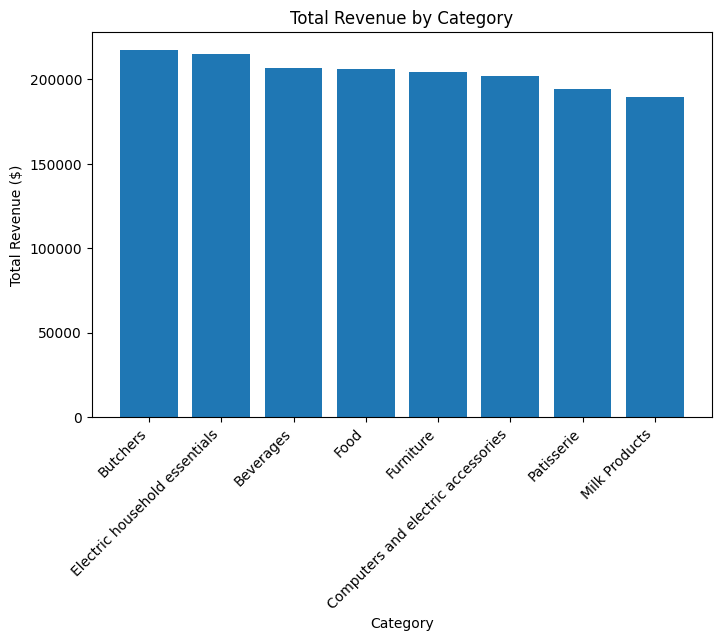

In [106]:
# Plot total revenue by category
plt.figure(figsize=(8, 5))
plt.bar(category_sales.index, category_sales['total_revenue'])
plt.title('Total Revenue by Category')
plt.xlabel('Category')
plt.ylabel('Total Revenue ($)')
plt.xticks(rotation=45,ha = 'right')
plt.show()

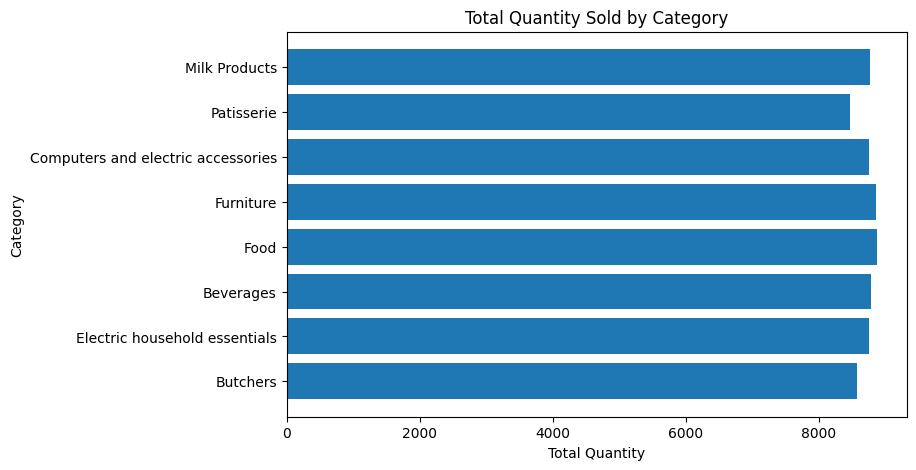

In [107]:
# Plot total quantity sold by category
plt.figure(figsize=(8, 5))
plt.barh(category_sales.index, category_sales['total_quantity'])
plt.title('Total Quantity Sold by Category')
plt.xlabel('Total Quantity')
plt.ylabel('Category')
plt.show()

#### Insights: Sales Performance by Category

The analysis reveals that all product categories have a relatively similar sales volume 
(approximately 8,400–8,800 units sold), yet the total revenue generated varies notably across categories.  

**Butchers** stands out as the highest-revenue category (~$217K), despite not having the highest number of units sold.  
This suggests a higher price-per-unit compared to other categories, indicating strong revenue efficiency.  
In contrast, categories such as **Food**, **Beverages**, and **Patisserie** show similar sales volume but generate lower total revenue, 
likely due to lower unit prices.

This pattern highlights the importance of product pricing strategy:  
high-demand categories do not necessarily drive the most revenue — **high-value categories do**.  
If business goals include profitability rather than volume alone, reinforcing premium-priced categories (e.g., Butchers) 
may yield better returns than pushing high-quantity but lower-margin categories.

### 2. Discount Impact Analysis

To evaluate the effect of discounts on customer spending behavior, we compare transactions where a discount was applied (`Discount Applied = True`) versus those without a discount (`False`). 
We will explore whether discounts lead to higher transaction volume, higher spending, or simply reduce revenue per sale.

In [108]:
discount_summary = df.groupby('Discount Applied').agg(
    transaction_count=('Transaction ID', 'count'),
    avg_spent=('Total Spent', 'mean'),
    total_revenue=('Total Spent', 'sum')
)

discount_summary

,transaction_count,avg_spent,total_revenue
Discount Applied,,,
False,8356,129.621703,1083118.95
True,4219,130.787594,551792.86


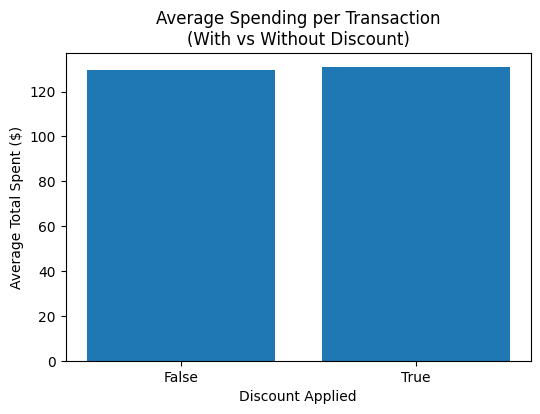

In [109]:
plt.figure(figsize=(6,4))
plt.bar(
    discount_summary.index.astype(str),
    discount_summary['avg_spent']
)
plt.title('Average Spending per Transaction\n(With vs Without Discount)')
plt.ylabel('Average Total Spent ($)')
plt.xlabel('Discount Applied')
plt.show()

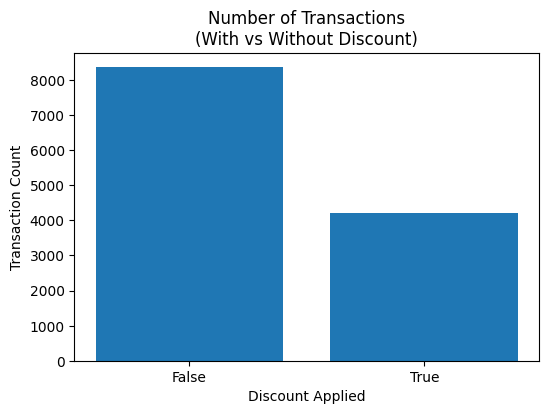

In [110]:
plt.figure(figsize=(6,4))
plt.bar(
    discount_summary.index.astype(str),
    discount_summary['transaction_count']
)
plt.title('Number of Transactions\n(With vs Without Discount)')
plt.ylabel('Transaction Count')
plt.xlabel('Discount Applied')
plt.show()

<Figure size 600x500 with 0 Axes>

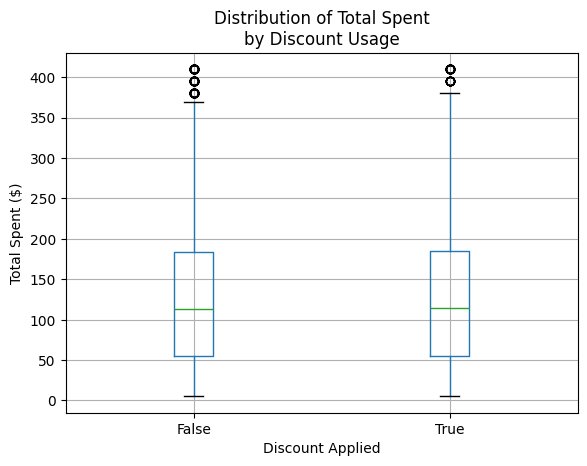

In [111]:
plt.figure(figsize=(6,5))
df.boxplot(column='Total Spent', by='Discount Applied')
plt.title('Distribution of Total Spent\nby Discount Usage')
plt.suptitle('')
plt.xlabel('Discount Applied')
plt.ylabel('Total Spent ($)')
plt.show()

#### Findings: Effect of Discounts on Sales

The analysis shows that discounts were applied in only about one-third of all transactions, and although these discounted purchases generated almost half of the total revenue, they did **not lead to higher spending per transaction**.  

The average order value is nearly the same with or without a discount, which suggests that discounts do not increase how much customers spend, but may instead attract a specific subset of buyers rather than driving overall sales volume.  

In short, discounts appear to influence **who buys**, not **how much they buy**.

### 3. Customer Lifetime Value (CLV) Analysis

To assess which customers contribute most to the company's revenue, we will calculate a simplified Customer Lifetime Value (CLV) metric by aggregating:
- Total spending per customer
- Number of transactions per customer
- Average order value (AOV) per customer

This approach helps identify the most valuable customers and supports targeted marketing or retention strategies.

In [112]:
customer_clv = df.groupby('Customer ID').agg(
    total_spent=('Total Spent', 'sum'),
    transaction_count=('Transaction ID', 'count'),
    avg_order_value=('Total Spent', 'mean'),
).sort_values(by='total_spent', ascending=False)

customer_clv.head(10)

,total_spent,transaction_count,avg_order_value
Customer ID,,,
CUST_24,71780.90,543,132.193186
CUST_08,70927.97,533,133.073114
CUST_05,70805.91,544,130.157923
CUST_23,68843.40,513,134.197661
CUST_13,68565.49,534,128.399794
CUST_16,68451.53,515,132.915592
CUST_21,65952.28,498,132.434297
CUST_10,65893.43,501,131.523812
CUST_15,65619.94,519,126.435337


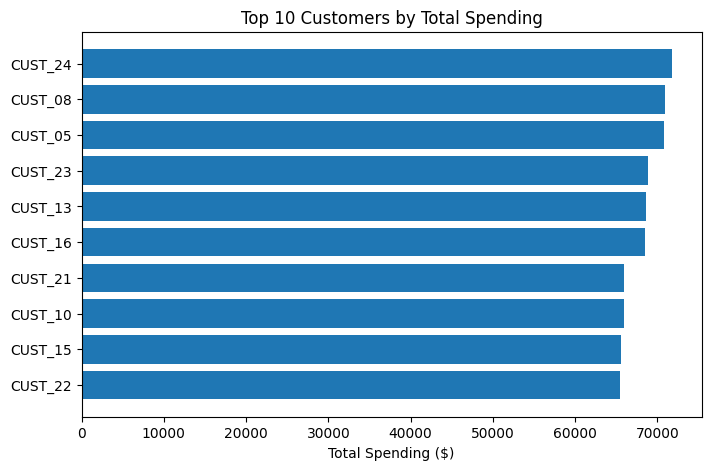

In [113]:
top_10_customers = customer_clv.head(10)

plt.figure(figsize=(8,5))
plt.barh(top_10_customers.index.astype(str), top_10_customers['total_spent'])
plt.xlabel('Total Spending ($)')
plt.title('Top 10 Customers by Total Spending')
plt.gca().invert_yaxis()
plt.show()

In [114]:
customer_clv['cum_revenue_percent'] = customer_clv['total_spent'].cumsum() / customer_clv['total_spent'].sum() * 100
customer_clv.head(10)

,total_spent,transaction_count,avg_order_value,cum_revenue_percent
Customer ID,,,,
CUST_24,71780.90,543,132.193186,4.390506
CUST_08,70927.97,533,133.073114,8.728842
CUST_05,70805.91,544,130.157923,13.059712
CUST_23,68843.40,513,134.197661,17.270545
CUST_13,68565.49,534,128.399794,21.464379
CUST_16,68451.53,515,132.915592,25.651243
CUST_21,65952.28,498,132.434297,29.685239
CUST_10,65893.43,501,131.523812,33.715636
CUST_15,65619.94,519,126.435337,37.729304


#### What We found

- The top customers make up a large part of total revenue.  
- Each of the top customers made more than 500 transactions and spent around $65K–$72K in total.  
- Their average order value is between $128–$135, which is similar across this group.  
- The top 10 customers alone account for about 40% of all revenue.

#### Why this matters

- These customers are very important for the business.  
- If even a few of them stop buying, total revenue could drop.  
- These customers are good targets for loyalty programs, special offers, or other retention strategies.

This analysis shows that keeping the right customers can be more valuable than making more sales.

### 4. Repeat vs One-Time Customer Behavior

To evaluate customer loyalty and retention, we compare one-time buyers with repeat customers.  
This helps us understand how much of the revenue comes from loyal vs. first-time customers, 
similar to SaaS-style analysis of churn and retention.

In [115]:
# Number of transactions per customer
customer_transactions = df.groupby('Customer ID')['Transaction ID'].nunique()

# Count one-time and repeat customers
one_time_customers = (customer_transactions == 1).sum()
repeat_customers = (customer_transactions > 1).sum()

one_time_customers, repeat_customers

(np.int64(0), np.int64(25))

In [116]:
# Total spending by each customer
total_spending_per_customer = df.groupby('Customer ID')['Total Spent'].sum()

# Add flags for one-time vs repeat
spending_df = pd.DataFrame({
    'total_spent': total_spending_per_customer,
    'transactions': customer_transactions
})
spending_df['type'] = spending_df['transactions'].apply(
    lambda x: 'Repeat' if x > 1 else 'One-Time'
)

# Revenue contribution
revenue_by_type = spending_df.groupby('type')['total_spent'].sum()
revenue_by_type

type
Repeat    1634911.81
Name: total_spent, dtype: float64

#### Findings

- There are **0 one-time customers** in the dataset.
- All **25 customers made multiple transactions**, meaning 100% of the customer base is classified as **repeat customers**.
- As a result, **100% of the total revenue ($1,634,911.81)** comes from repeat buyers.

#### Interpretation

This dataset represents a fully retained customer base with no single-purchase drop-offs.
While this is not typical in real retail data, it highlights an important point:

> Revenue is entirely driven by returning customers, which makes customer retention the key growth factor in this scenario.

## Conclusion

This project followed a complete data analysis workflow, starting from data cleaning and preparation to exploratory analysis and customer-level business insights.

### Key Outcomes

- All missing values in the dataset were identified, handled, and validated, resulting in a fully clean dataset ready for analysis.
- Category-level analysis showed that **Butchers, Electric Household Essentials, and Beverages** are the highest revenue-generating product groups.
- The use of discounts did **not significantly increase the average order value**, but it reduced the number of non-discount transactions, suggesting that discounts may be driving volume rather than higher spending per purchase.
- CLV (Customer Lifetime Value) analysis revealed that a **small number of customers contribute a large share of total revenue**, where the top 10 customers alone account for ~40% of total sales.
- Repeat-customer analysis showed that **100% of customers in this dataset are repeat buyers**, meaning retention is extremely strong and no single-purchase churn segment exists.

### Business Interpretation

The business relies heavily on a small set of high-value repeat customers.
Retention strategies (loyalty programs, personalized offers, premium services) are likely more valuable than new customer acquisition in this environment.
Discounts appear to motivate transactions but do not increase spending per order, so discount strategy should be optimized based on profit margins.